In [ ]:
# for only showing errors
import logging
log = logging.getLogger("lightning.pytorch")
log.propagate = False
log.setLevel(logging.ERROR)

# for basic data manipulations
import pandas as pd
import numpy as np

# for handling file paths
import os
import tqdm

# for getting clustered data
from cluster import get_daily_sales

# for TFT and hyperparameter tuning
from tft.configs import CrossValConfigs, DataSetConfigs, TFTConfigs
from tft.tft import TFT
from tft.tuner import Tuner

# for model evaluation
from evaluator import Evaluator

# for MAPE computation
from sklearn.metrics import mean_absolute_percentage_error

# for TFT modelling
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl
from pytorch_optimizer import Ranger
from pytorch_forecasting.metrics import MAPE
import torch


# for time series preprocessing
from scipy.signal import savgol_filter

# for hyperparameter tuning
from ray import tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback

# for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')


In [7]:
def add_cluster_idx(df, idx):
    df["cluster_id"] = f"cluster_{idx}"
    return df

In [8]:
sales = list(map(lambda x: get_daily_sales(x).reset_index(), [1, 5, 7]))
sales_ = list(map(add_cluster_idx, sales, [1, 5, 7]))
data = pd.concat(sales_).reset_index(drop = True)

In [9]:
data['TotalSales'] = savgol_filter(data['TotalSales'], window_length=9, polyorder=2)

data["date"] = pd.to_datetime(data["date"])
data["time_idx"] = (data["date"] - data["date"].min()).dt.days

data["month"] = data["date"].dt.month.astype(str).astype("category")
data["year"] = data["date"].dt.year.astype(str).astype("category")
data["day_of_week"] = data["date"].dt.dayofweek.astype(str).astype("category")
data["day_of_month"] = data["date"].dt.day.astype(str).astype("category")
data["is_weekend"] = (data["date"].dt.dayofweek >= 5).astype(int)

In [10]:
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['cluster_id', 'date'])

# statistics by group_idx
def create_features(group):
    # 1st and 7th lag
    group['lag_1'] = group['TotalSales'].shift(1)
    group['lag_7'] = group['TotalSales'].shift(7)
    
    # rolling mean and sd
    for window in [3, 7, 14, 30]:
        group[f'rolling_mean_{window}'] = group['TotalSales'].rolling(window).mean().bfill()
        group[f'rolling_std_{window}'] = group['TotalSales'].rolling(window).std().bfill()
    
    # exponential moving average
    group['ema_7'] = group['TotalSales'].ewm(span=7, adjust=False).mean()
    
    # first order difference
    group['daily_diff'] = group['TotalSales'].diff(1)
    
    return group

data = data.groupby('cluster_id', group_keys=False).apply(create_features)
data = data.dropna()

In [13]:
data = data.sort_values(by = "time_idx").reset_index()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1791 entries, 0 to 1790
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            1791 non-null   int64         
 1   date             1791 non-null   datetime64[ns]
 2   TotalSales       1791 non-null   float64       
 3   cluster_id       1791 non-null   object        
 4   time_idx         1791 non-null   int64         
 5   month            1791 non-null   category      
 6   year             1791 non-null   category      
 7   day_of_week      1791 non-null   category      
 8   day_of_month     1791 non-null   category      
 9   is_weekend       1791 non-null   int64         
 10  lag_1            1791 non-null   float64       
 11  lag_7            1791 non-null   float64       
 12  rolling_mean_3   1791 non-null   float64       
 13  rolling_std_3    1791 non-null   float64       
 14  rolling_mean_7   1791 non-null   float64

In [ ]:
param_space = {
    "lr": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([16, 32, 64]),
    "dropout": tune.uniform(0.1, 0.3),
}


t = Tuner(
    data = data,
    configs = {
        "dataset": DataSetConfigs(),
        "tft": TFTConfigs()
    },
    param_space = param_space,
    num_samples = 15
)

In [ ]:
t.tune()

2025-05-05 01:00:54,737	INFO worker.py:1852 -- Started a local Ray instance.
2025-05-05 01:00:56,454	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-05-05 01:00:56,457	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-05-05 01:00:56,459	INFO registry.py:112 -- Detected unknown callable for trainable. Converting to class.
2025-05-05 01:00:56,489	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2025-05-05 01:00:56,490	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(train pid=438) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(train pid=438) INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(train pid=438) INFO: GPU available: True (cuda), used: True
(train pid=438) INFO: TPU available: False, using: 0 TPU cores
(train pid=438) INFO: HPU available: False, using: 0 HPUs
(train pid=438) /usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(train pid=438) /usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: At

Trial name,val_loss
train_66a5e_00000,0.356963
train_66a5e_00001,0.326644
train_66a5e_00002,0.355682
train_66a5e_00003,0.317496
train_66a5e_00004,0.351394
train_66a5e_00005,0.297015
train_66a5e_00006,0.341469
train_66a5e_00007,0.304995
train_66a5e_00008,0.337746
train_66a5e_00009,0.344532


(train pid=504) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(train pid=504) INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(train pid=504) INFO: GPU available: True (cuda), used: True
(train pid=504) INFO: TPU available: False, using: 0 TPU cores
(train pid=504) INFO: HPU available: False, using: 0 HPUs
(train pid=504) /usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
(train pid=504) /usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: At

train_66a5e_00014

In [ ]:
TFTConfigs(
    lr = 0.00018211,
    hidden_size = 16,
    dropout = 0.287617
)

tft = TFT(
    data = data,
    configs = {
        "cross_validation": CrossValConfigs(),
        "dataset": DataSetConfigs(),
        "tft": TFTConfigs()
    }
)

In [ ]:
tft.cross_validate(
    MIN_TIME_IDX = data["time_idx"].min(),
    MAX_TIME_IDX = data["time_idx"].max()
)

cross-validation: 100%|██████████| 61/61 [20:52<00:00, 20.53s/window]


In [ ]:
e = Evaluator(tft.cv_results)

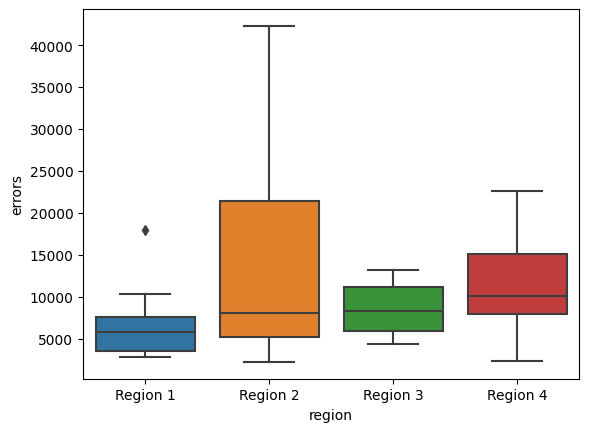

In [ ]:
e.forecast_error_by_region(regions = 4)

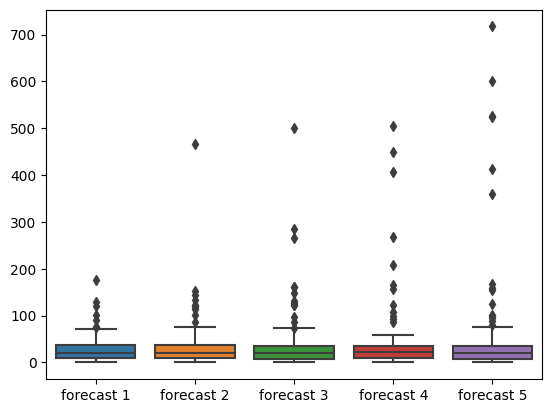

In [ ]:
e.mape_by_forecast()

In [ ]:
e.mape_df.describe()

,forecast 1,forecast 2,forecast 3,forecast 4,forecast 5
count,183.000000,183.000000,183.000000,183.000000,183.000000
mean,26.406368,29.679260,32.047146,34.837460,42.014076
std,24.116287,42.226707,52.000633,63.721012,95.294357
min,0.036798,0.057827,0.144606,0.177644,0.124849
25%,10.556543,9.992717,7.681829,9.167361,7.889667
50%,21.148243,20.489651,20.210089,22.599585,19.689610
75%,36.658211,36.517828,34.394047,34.332932,34.894808
max,175.469482,465.773865,499.618530,503.764923,717.216614
